In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"Loaded {len(dfs)} recordings")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class DS1DCNNClassifier(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super().__init__()
        self.features = nn.Sequential(
            DepthwiseSeparableConv1D(num_features, 64, kernel_size=7, padding=3),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),

            DepthwiseSeparableConv1D(64, 128, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),

            DepthwiseSeparableConv1D(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

In [5]:
def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])

    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)

    print(f"Dataset: {X.shape[0]} windows | "
          f"{X.shape[1]} timesteps | {X.shape[2]} features")
    return X, y, groups

In [6]:
def train_fold(X_train, y_train, X_val, y_val, le):
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)
    X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    y_train = le.transform(y_train)
    y_val = le.transform(y_val)

    train_loader = DataLoader(MotionDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DS1DCNNClassifier(num_features=X_train.shape[2], num_classes=len(le.classes_), dropout=DROPOUT).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    best_loss = np.inf
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        preds_all, true_all = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                preds_all.extend(preds.argmax(1).cpu().numpy())
                true_all.extend(yb.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model, true_all, preds_all

def evaluate_cnn(X, y, groups, title="DS 1D CNN Results"):
    le = LabelEncoder()
    le.fit(y)
    gkf = GroupKFold(n_splits=5)
    y_true_all, y_pred_all = [], []

    for fold, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        print(f"\n=== Fold {fold} ===")
        model, yt, yp = train_fold(X[tr], y[tr], X[va], y[va], le)
        y_true_all.extend(yt)
        y_pred_all.extend(yp)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_, digits=4))

    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Oranges")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

Loaded 100 recordings
Dataset: 5025 windows | 100 timesteps | 6 features

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== DS CNN – Raw Features ===
              precision    recall  f1-score   support

         run     1.0000    0.9928    0.9964      1250
         sit     0.9772    0.9952    0.9861      1250
      stairs     0.9638    0.9804    0.9720      1275
        walk     0.9769    0.9488    0.9627      1250

    accuracy                         0.9793      5025
   macro avg     0.9795    0.9793    0.9793      5025
weighted avg     0.9794    0.9793    0.9793      5025



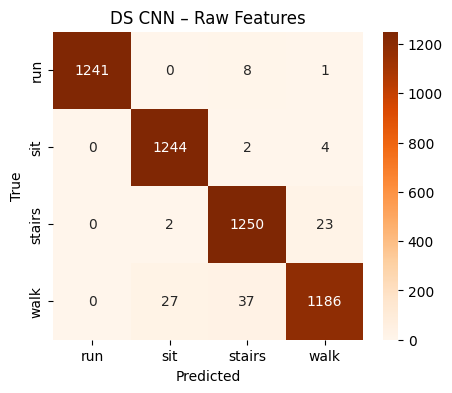

Dataset: 5025 windows | 100 timesteps | 6 features

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== DS CNN – GFT Features ===
              precision    recall  f1-score   support

         run     0.9975    0.9520    0.9742      1250
         sit     0.9378    0.9528    0.9452      1250
      stairs     0.9142    0.9278    0.9210      1275
        walk     0.8793    0.8920    0.8856      1250

    accuracy                         0.9311      5025
   macro avg     0.9322    0.9312    0.9315      5025
weighted avg     0.9321    0.9311    0.9315      5025



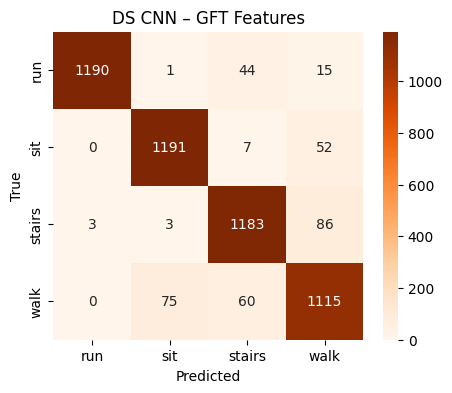

In [7]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw = build_dataset(recordings, RAW_FEATURES)
    evaluate_cnn(X_raw, y_raw, g_raw, title="DS CNN – Raw Features")

    X_gft, y_gft, g_gft = build_dataset(recordings, GFT_FEATURES)
    evaluate_cnn(X_gft, y_gft, g_gft, title="DS CNN – GFT Features")